In [69]:
import xarray as xr
from pathlib import Path
import platform
import yaml
import numpy as np
from ascat.read_native.ragged_array_ts import CellFileCollection
from tqdm import tqdm  # import tqdm for progress bar
import matplotlib.pyplot as plt
import rioxarray
from rasterio.warp import transform

## Plans

Now we want to match the Sentinel1 6km Equi7 grid to the Ascat 12.5km Fibonaccy grid. We just want to align the spatial resolution. We will not align the time dimension. We could use
- Nearest Neighbour (not super nice as we have 6km and 12.5km resolution)
- Some Interpolation Technique

When we look at the pixle size it would be recommended to use around nine 6km pixles from the rasta data for one 12.5km pixle in the point data.

sig_dc_linear_12p5_fibgrid = sig_dc_linear_6p25_fibgrid.nearest.neighbour

sig_dc_12p5_fibgrid = 10 * np.log10(sig_dc_linear_12p5_fibgrid)
sig_dc_12p5_fibgrid

### Loading Sentinel 1 data

In [47]:
sentinel_ds = xr.open_zarr("output_6km_filled.zarr")
sentinel_ds

<xarray.Dataset> Size: 6kB
Dimensions:      (time: 2, y: 22, x: 17)
Coordinates:
    spatial_ref  int32 4B ...
  * time         (time) datetime64[ns] 16B 2022-01-06T05:00:00 2022-01-07T17:...
  * x            (x) float64 136B 4.483e+06 4.489e+06 ... 4.573e+06 4.578e+06
  * y            (y) float64 176B 1.382e+06 1.376e+06 ... 1.262e+06 1.259e+06
Data variables:
    VH           (time, y, x) float32 3kB dask.array<chunksize=(1, 21, 16), meta=np.ndarray>
    VV           (time, y, x) float32 3kB dask.array<chunksize=(1, 21, 16), meta=np.ndarray>

In [ ]:
# get bounds for ASCAT data from S1

# is this a good approach? look at step 1 to see why

sentinel_ds = sentinel_ds.rio.write_crs(sentinel_ds.spatial_ref.attrs['crs_wkt'])

bounds_proj = sentinel_ds.rio.bounds()

sentinel_ds_latlon = sentinel_ds.rio.reproject("EPSG:4326")
latmin = float(sentinel_ds_latlon.y.min())
latmax = float(sentinel_ds_latlon.y.max())
lonmin = float(sentinel_ds_latlon.x.min())
lonmax = float(sentinel_ds_latlon.x.max())

print(f"latmin: {latmin}, latmax: {latmax}")
print(f"lonmin: {lonmin}, lonmax: {lonmax}")

latmin: 43.900102740150416, latmax: 45.09043357213728
lonmin: 6.776895797829642, lonmax: 8.217822594445318


We can see that we do not get the exact defined lat and lon we defined but a slightly bigger area. This should not be a problem in our further analysis.

### Reading ASCAT data points

In [ ]:
# read yaml for reading data on Windows, Linux or the JupyterHub
paths = yaml.safe_load(Path("../paths.yml").read_text())
root = Path(paths["windows" if platform.system() == "Windows" else "linux"]).expanduser()
cell_source = root / "datasets/scat_ard/ascat_ssm_cdr_12.5km_h121"
assert cell_source.exists(), f"Path does not exist: {cell_source}"

In [45]:
h121_reader = CellFileCollection.from_product_id(cell_source, "H121_V1.0")
gpis, lons, lats, cells = h121_reader.grid.get_grid_points()

indices = np.where(
    (lats >= latmin) & (lats <= latmax) & (lons >= lonmin) & (lons <= lonmax)
)[0]

print("There are", len(indices), "point indices inside specified bounding box")

selected_coords = list(zip(lons[indices], lats[indices]))
selected_gpis = gpis[indices]

datasets = []

for id in tqdm(selected_gpis, desc="Loading locations"):
    ds = h121_reader.read(location_id=id)
    ds = ds.swap_dims({"obs": "time"})
    
    ds_single_time = ds.isel(time=0)
    
    # Expand dims to keep consistent shape for concatenation
    ds_single_time = ds_single_time.expand_dims(location_id=[id])
    datasets.append(ds_single_time)

ascat_ds = xr.concat(datasets, dim="location_id")
ascat_ds

c:\Users\jwagner\AppData\Local\anaconda3\envs\ascat-s1-synergy\lib\site-packages\ascat\read_native\ragged_array_ts.py:945: UserWarning: Could not determine date range for collection 'ascat_ssm_cdr_12' from directory name. Using min/max datetime from files instead.
  warnings.warn(


There are 98  point indices inside specified bounding box


Loading locations: 100%|██████████| 98/98 [02:14<00:00,  1.38s/it]


<xarray.Dataset> Size: 8kB
Dimensions:                            (location_id: 98)
Coordinates:
  * location_id                        (location_id) int32 392B 1140248 ... 1...
    lon                                (location_id) float32 392B 7.057 ... 8...
    lat                                (location_id) float32 392B 43.91 ... 4...
    alt                                float32 4B 9.969e+36
    time                               (location_id) datetime64[ns] 784B 2007...
Data variables: (12/20)
    locationIndex                      (location_id) int32 392B 1164 1167 ... 24
    location_description               (location_id) <U1 392B '' '' '' ... '' ''
    as_des_pass                        (location_id) int8 98B 0 0 0 0 ... 0 0 0
    swath_indicator                    (location_id) int8 98B 1 1 1 1 ... 1 1 1
    surface_flag                       (location_id) uint8 98B 0 0 0 0 ... 0 0 0
    surface_soil_moisture              (location_id) float32 392B 59.14 ... 5...
    ...                                 ...
    snow_cover_probability             (location_id) float64 784B 97.0 ... 36.0
    frozen_soil_probability            (location_id) float64 784B 39.0 ... 26.0
    wetland_fraction                   (location_id) int8 98B 0 0 0 0 ... 0 1 0
    topographic_complexity             (location_id) int8 98B 25 31 32 ... 24 4
    subsurface_scattering_probability  (location_id) float64 784B nan ... nan
    sat_id                             (location_id) int8 98B 3 3 3 3 ... 3 3 3
Attributes:
    id:            1358.nc
    date_created:  2025-01-09 12:40:43
    featureType:   timeSeries

### Mapping the Sentinel 1 data 
We want to map the data to the Fibonaccy Pointgrid to match the 12.5km resolution ASCAT data

Possible approaches:
- Nearest neighbour (but resolution does not seem to be that nice) -> should i increase the sentinel resolution?
- Interpolation

#### Step 1
Reproject the ASCAT points to the Sentinel 1 raster

In [72]:
ascat_crs = "EPSG:4326"                        # ASCAT in geographic coordinates
sentinel_crs = sentinel_ds.rio.crs.to_string() # Sentinel-1 in projected CRS (e.g., EPSG:3035)

ascat_x, ascat_y = transform(
    src_crs=ascat_crs,
    dst_crs=sentinel_crs,
    xs=ascat_ds["lon"].values,
    ys=ascat_ds["lat"].values,
)

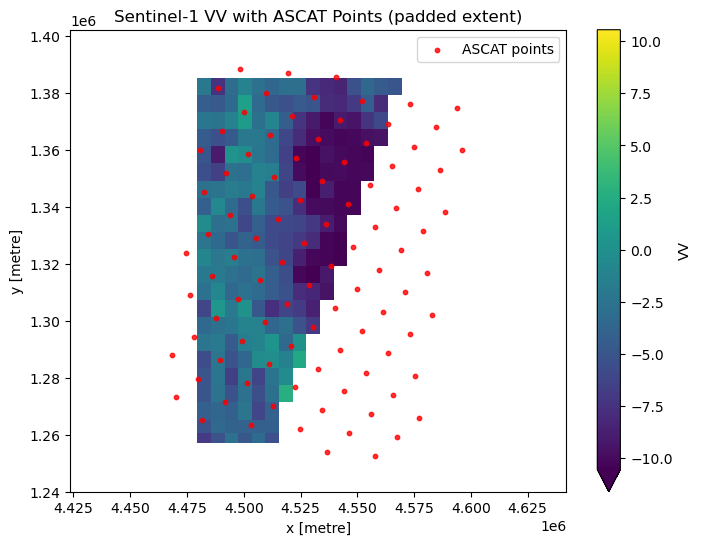

In [ ]:
# visual check

x_min = min(np.min(ascat_x), sentinel_ds.x.min().item())
x_max = max(np.max(ascat_x), sentinel_ds.x.max().item())
y_min = min(np.min(ascat_y), sentinel_ds.y.min().item())
y_max = max(np.max(ascat_y), sentinel_ds.y.max().item())

vv_img = sentinel_ds["VV"].isel(time=0)

fig, ax = plt.subplots(figsize=(8, 6))
vv_img.plot(ax=ax, cmap="viridis", robust=True)

ax.scatter(ascat_x, ascat_y, s=10, c='red', label="ASCAT points", alpha=0.8)

ax.set_xlim(0.99*x_min, 1.01*x_max)
ax.set_ylim(0.99*y_min, 1.01*y_max)

ax.set_title("Sentinel-1 VV with ASCAT Points")
ax.legend()
plt.show()

#### Step 2
Sample raster values at the coordinates of the points

#### Step 3
Attach samples values to the ascat points

### The Output should be in the same format as the ascat data

In [46]:
h121_reader = CellFileCollection.from_product_id(cell_source, "H121_V1.0")
gpis, lons, lats, cells = h121_reader.grid.get_grid_points()

indices = np.where(
    (lats >= latmin) & (lats <= latmax) & (lons >= lonmin) & (lons <= lonmax)
)[0]

print("There are", len(indices), "point indices inside specified bounding box")

selected_coords = list(zip(lons[indices], lats[indices]))
selected_gpis = gpis[indices]

datasets = []

for id in tqdm(selected_gpis, desc="Loading locations"):
    ds = h121_reader.read(location_id=id)
    ds = ds.swap_dims({"obs": "time"})
        
    # Expand dims to keep consistent shape for concatenation
    ds = ds.expand_dims(location_id=[id])
    datasets.append(ds)

ascat_ds = xr.concat(datasets, dim="location_id")
ascat_ds

c:\Users\jwagner\AppData\Local\anaconda3\envs\ascat-s1-synergy\lib\site-packages\ascat\read_native\ragged_array_ts.py:945: UserWarning: Could not determine date range for collection 'ascat_ssm_cdr_12' from directory name. Using min/max datetime from files instead.
  warnings.warn(


There are 98 point indices inside specified bounding box


Loading locations: 100%|██████████| 98/98 [02:19<00:00,  1.42s/it]


<xarray.Dataset> Size: 4GB
Dimensions:                            (location_id: 98, time: 474302)
Coordinates:
  * time                               (time) datetime64[ns] 4MB 2007-01-01T2...
  * location_id                        (location_id) int32 392B 1140248 ... 1...
    lon                                (location_id) float32 392B 7.057 ... 8...
    lat                                (location_id) float32 392B 43.91 ... 4...
    alt                                float32 4B 9.969e+36
Data variables: (12/20)
    locationIndex                      (location_id, time) float64 372MB nan ...
    location_description               (location_id) <U1 392B '' '' '' ... '' ''
    as_des_pass                        (location_id, time) float32 186MB nan ...
    swath_indicator                    (location_id, time) float32 186MB nan ...
    surface_flag                       (location_id, time) float32 186MB nan ...
    surface_soil_moisture              (location_id, time) float32 186MB nan ...
    ...                                 ...
    snow_cover_probability             (location_id, time) float64 372MB nan ...
    frozen_soil_probability            (location_id, time) float64 372MB nan ...
    wetland_fraction                   (location_id, time) float32 186MB nan ...
    topographic_complexity             (location_id, time) float32 186MB nan ...
    subsurface_scattering_probability  (location_id, time) float64 372MB nan ...
    sat_id                             (location_id, time) float32 186MB nan ...
Attributes:
    id:            1358.nc
    date_created:  2025-01-09 12:40:43
    featureType:   timeSeries